# Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

# Data

Datalink : https://www.surveypractice.org/article/13669-minnesota-social-contacts-and-mixing-patterns-survey-with-implications-for-modelling-of-infectious-disease-transmission-and-control

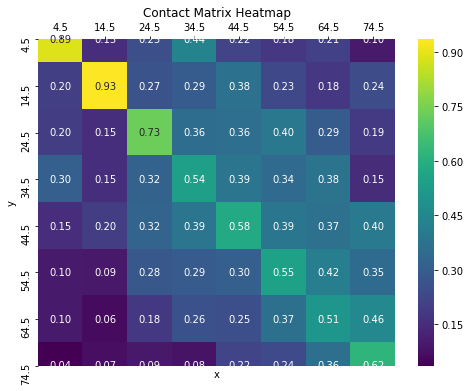

In [2]:
x = np.array([4.5,14.5,24.5,34.5,44.5,54.5,64.5,74.5])
y = np.array([4.5,14.5,24.5,34.5,44.5,54.5,64.5,74.5])

# Define the contact matrix

matrix = np.array([
    [5.15, 1.31, 1.24, 2.24, 1.09, 0.60, 0.48, 0.21],
    [1.18, 8.06, 1.30, 1.50, 1.88, 0.78, 0.41, 0.52],
    [1.14, 1.32, 3.60, 1.82, 1.79, 1.35, 0.68, 0.41],
    [1.77, 1.32, 1.57, 2.76, 1.93, 1.16, 0.87, 0.32],
    [0.88, 1.70, 1.58, 1.98, 2.90, 1.32, 0.85, 0.87],
    [0.56, 0.81, 1.38, 1.49, 1.52, 1.86, 0.96, 0.75],
    [0.57, 0.54, 0.89, 1.33, 1.26, 1.24, 1.17, 0.99],
    [0.21, 0.59, 0.46, 0.41, 1.08, 0.81, 0.83, 1.34],
])

# Calculate magnitude of each row
magnitudes = np.linalg.norm(matrix, axis=0)

# Divide each element by its magnitude
normalized_matrix = (matrix / magnitudes)

# Plot heatmap with values
plt.figure(figsize=(8,6))
ax = sns.heatmap(normalized_matrix, cmap='viridis', annot=True, fmt=".2f", xticklabels=x, yticklabels= y)
ax.xaxis.tick_top()
plt.title('Contact Matrix Heatmap')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


# Parameters

In [3]:
beta = 0.11    # transmission rate
gamma = 1/14   # recovery rate
N = 1          # total population
R0 = 0         # Number of recovered people, initially
I0 = 0.01      # Number of infected people, initially
S0 = N - I0 - R0 # Number of susceptible people, initially

In [4]:
#x = np.array([5,15,25,35,45,55,65,75])
#y = np.array([5,15,25,35,45,55,65,75])

#z_values = np.linspace(0, 1, len(y))  # Use linspace to ensure z_values has the same length as y
#z_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
z_values = np.array([0.2, 0.4, 0.6, 0.3, 0.8, 0.1, 0.9, 0.5])
#z_values= np.array([0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3])

# ODE's for SIR model with contact matrix

In [5]:
# Define ODE's for SIR model with contact matrix
def dzdt(t, k, beta, gamma, x, y, noramlized_matrix,z_values):
    S = k[:len(x)]
    I = k[len(x):2*len(x)]
    R = k[2*len(x):]
    
    integral_term_values = np.dot(noramlized_matrix, I)        
    
    dSdt = -beta * S * integral_term_values / N
    dIdt = beta * S * integral_term_values / N - gamma * I
    dRdt = gamma * I
    
    return np.concatenate([dSdt, dIdt, dRdt])

# Time step

In [6]:
dt = 0.01  # Adjust the time step according
t_span = (0,100)
t_eval = np.arange(t_span[0], t_span[1] + dt, dt)

# Initial conditions for each location

In [7]:
initial_conditions = np.concatenate([S0 * np.ones(len(x)), I0 * np.ones(len(x)), R0 * np.zeros(len(x))])

# Solve the ODE'S

In [8]:
solution_original = solve_ivp(
    fun=lambda t, k: dzdt(t, k, beta, gamma, x, y, normalized_matrix,z_values),
    t_span=t_span,
    y0=initial_conditions,
    t_eval=t_eval,
    method='RK45'
)

# Scaled the results

In [9]:
scaled_results_original = solution_original.y

# what happens if we want to prevent infections from one group to the other by lockdowns, 'isolation' of older people etc

# Implement Modified Contact Matrix

In [10]:
# For reducing interactions between older people (age > 70) and other age groups
modified_contact_matrix = normalized_matrix.copy()
modified_contact_matrix[x > 70, :] *= 0.1 # reduce interactions by 90%

# Solve the ODE'S  For Modified Contact Matrix

In [11]:
solution_modified = solve_ivp(
    fun=lambda t, k: dzdt(t, k, beta, gamma, x, y, modified_contact_matrix,z_values),
    t_span=t_span,
    y0=initial_conditions,
    t_eval=t_eval,
    method='RK45'
)

scaled_results_modified = solution_modified.y

# plot and compare the results

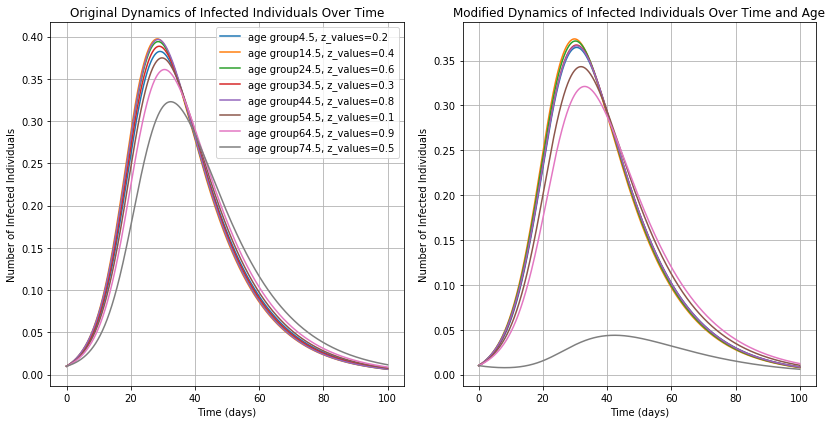

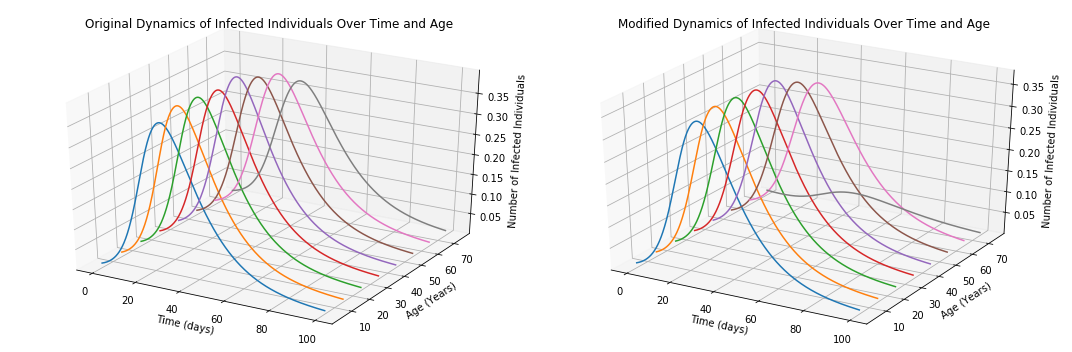

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
# For 2D plot

# Plot for original scenario
for i in range(len(x)):
    ax[0].plot(solution_original.t, scaled_results_original[i + len(x), :], label=f'age group{x[i]}, z_values={z_values[i]}')

ax[0].set_title('Original Dynamics of Infected Individuals Over Time')
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('Number of Infected Individuals')
ax[0].grid()
ax[0].legend()

# Plot for modified scenario
for i in range(len(x)):
    ax[1].plot(solution_modified.t, scaled_results_modified[i + len(x), :])

ax[1].set_title('Modified Dynamics of Infected Individuals Over Time and Age')
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Number of Infected Individuals')
ax[1].grid()


plt.tight_layout()
plt.show()


# For Plotting 3D
fig = plt.figure(figsize=(15, 5))

# Plot for original scenario
ax1 = fig.add_subplot(121, projection='3d')
for i in range(len(x)):
    ax1.plot(solution_original.t, np.full_like(solution_original.t, x[i]), scaled_results_original[i + len(x), :])

ax1.set_title('Original Dynamics of Infected Individuals Over Time and Age')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Age (Years)')
ax1.set_zlabel('Number of Infected Individuals')

# Plot for scenario with reducing contact
ax2 = fig.add_subplot(122, projection='3d')
for i in range(len(x)):
    ax2.plot(solution_modified.t, np.full_like(solution_modified.t, x[i]), scaled_results_modified[i + len(x), :])

ax2.set_title('Modified Dynamics of Infected Individuals Over Time and Age')
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Age (Years)')
ax2.set_zlabel('Number of Infected Individuals')

plt.tight_layout()
plt.show()


In [13]:
peak_infections = [round(np.max(scaled_results_original[i + len(x), :]), 3) for i in range(len(x))]
print("Peak Infections for each age group:", peak_infections)


Peak Infections for each age group: [0.382, 0.397, 0.394, 0.389, 0.397, 0.375, 0.361, 0.323]


In [14]:
peak_infections = [round(np.max(scaled_results_modified[i + len(x), :]), 3) for i in range(len(x))]
print("Peak Infections for each age group:", peak_infections)


Peak Infections for each age group: [0.365, 0.374, 0.372, 0.367, 0.366, 0.343, 0.321, 0.044]


In [15]:
# Iterate through each age group
for i, age_group in enumerate(x):
    # Extract the infected individuals for the current age group
    infected_individuals = scaled_results_original[i + len(x)]
    
    # Find the index of the peak value (maximum value) of infected individuals for the current age group
    peak_index = np.argmax(infected_individuals)
    
    # Determine the corresponding day for the peak value
    peak_day = solution_original.t[peak_index]
    
    print(f"Peak day for age group {age_group}: {peak_day}")


Peak day for age group 4.5: 29.14
Peak day for age group 14.5: 28.28
Peak day for age group 24.5: 28.55
Peak day for age group 34.5: 28.88
Peak day for age group 44.5: 28.53
Peak day for age group 54.5: 29.75
Peak day for age group 64.5: 30.53
Peak day for age group 74.5: 32.45


In [16]:
# Iterate through each age group
for i, age_group in enumerate(x):
    # Extract the infected individuals for the current age group
    infected_individuals = scaled_results_modified[i + len(x)]
    
    # Find the index of the peak value (maximum value) of infected individuals for the current age group
    peak_index = np.argmax(infected_individuals)
    
    # Determine the corresponding day for the peak value
    peak_day = solution_modified.t[peak_index]
    
    print(f"Peak day for age group {age_group}: {peak_day}")

Peak day for age group 4.5: 30.52
Peak day for age group 14.5: 29.85
Peak day for age group 24.5: 30.14
Peak day for age group 34.5: 30.45
Peak day for age group 44.5: 30.490000000000002
Peak day for age group 54.5: 31.86
Peak day for age group 64.5: 33.0
Peak day for age group 74.5: 42.32
